# 处理昊臻实验数据

## 4.8-4.11-10s稳态性能测试

In [1]:
import gzip, os, pickle
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

from keys import Cols
from utils.data_preprocess import Hyzenis_clean_excel_file

### 处理缺失值（-9999与前后形成等差数列）

In [2]:
input_file_path = r'D:\Devs\Simulation-Platform\data\raw\Test data Hyzenis\2025.04.08-8.30-2025.04.11-17.30-10s-1#.xlsx'

df_missing_values = Hyzenis_clean_excel_file(input_file_path=input_file_path)
df_missing_values['时间'] = pd.to_datetime(df_missing_values['时间'])

d:\Devs\Simulation-Platform\src\utils\data_preprocess.py:443: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
d:\Devs\Simulation-Platform\src\utils\data_preprocess.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[prev_non_nan.index[-1] + i] = prev_val + i * step
d:\Devs\Simulation-Platform\src\utils\data_preprocess.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[prev_non_nan.index[-1] + i] = prev_val + i * step
d:\Devs\Simulation-Platform\src\utils\data_preprocess.py:464: SettingWithCopyWarnin

### 依照keys重命名数据中的变量名

In [3]:
# 定义列名映射字典
column_mapping = {
    '时间': Cols.date_time,
    '1#碱液流量': Cols.lye_flow,
    '1#碱液温度': Cols.lye_temp,
    '1#氧槽温度': Cols.temp_O,
    '1#氢槽温度': Cols.temp_H,
    '1#电流显示': Cols.current,
    '1#电压显示': Cols.voltage,
    '氧中氢': Cols.HTO,
    '氢中氧': Cols.OTH,
}

# 使用 rename 方法批量重命名列名
df_renamed = df_missing_values.rename(columns=column_mapping)

### 计算衍生的变量

In [4]:
df_additive = df_renamed

# 计算小室电压
Num_cells = 31
df_additive[Cols.cell_voltage] = df_additive[Cols.voltage] / 31

# 计算电流密度
Diameter_Electrode = 560 * 1E-3
Area_Electrode = math.pi * (Diameter_Electrode / 2) ** 2
df_additive[Cols.current_density] = df_additive[Cols.current] / Area_Electrode

# 计算出口温度
df_additive[Cols.temp_out] = (df_additive[Cols.temp_H] + df_additive[Cols.temp_O]) / 2

# 计算槽内压力
df_additive[Cols.pressure] = (df_additive['氧分离器压力'] + df_additive['氢分离器压力'])

### 生成环境温度

d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Devs\Simulation-Platform\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDE

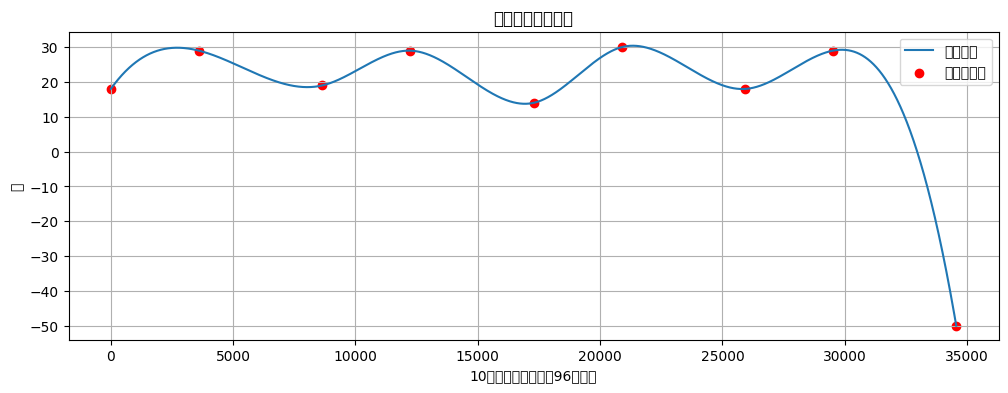

In [5]:
from scipy.interpolate import CubicSpline

# 原始数据点（x为10秒点数，y为值）
x = np.array([0, 3600, 8640, 12240, 17280, 20880, 25920, 29520, 34560])
y = np.array([18, 29, 19, 29, 14, 30, 18, 29, -50])

# 生成三次样条插值函数
cs = CubicSpline(x, y)

# 生成10秒间隔的连续x值（从0到34560）
x_continuous = np.arange(0, 34561)  # 包含34561个点（0到34560）
y_smooth = cs(x_continuous)

# 绘制曲线
plt.figure(figsize=(12, 4))
plt.plot(x_continuous, y_smooth, label='平滑曲线')
plt.scatter(x, y, color='red', label='原始数据点')
plt.xlabel('10秒点数（总时长：96小时）')
plt.ylabel('值')
plt.title('平滑曲线拟合结果')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
df_temp_envi = df_additive
# 起始时间为4月8日4点，总时长96小时，结束时间为4月12日4点

# 删除4点到8点30 10s一个点 共1620个点
temp_envi = y_smooth[1620: 1620+len(df_temp_envi)]

df_temp_envi[Cols.temp_environment] = temp_envi

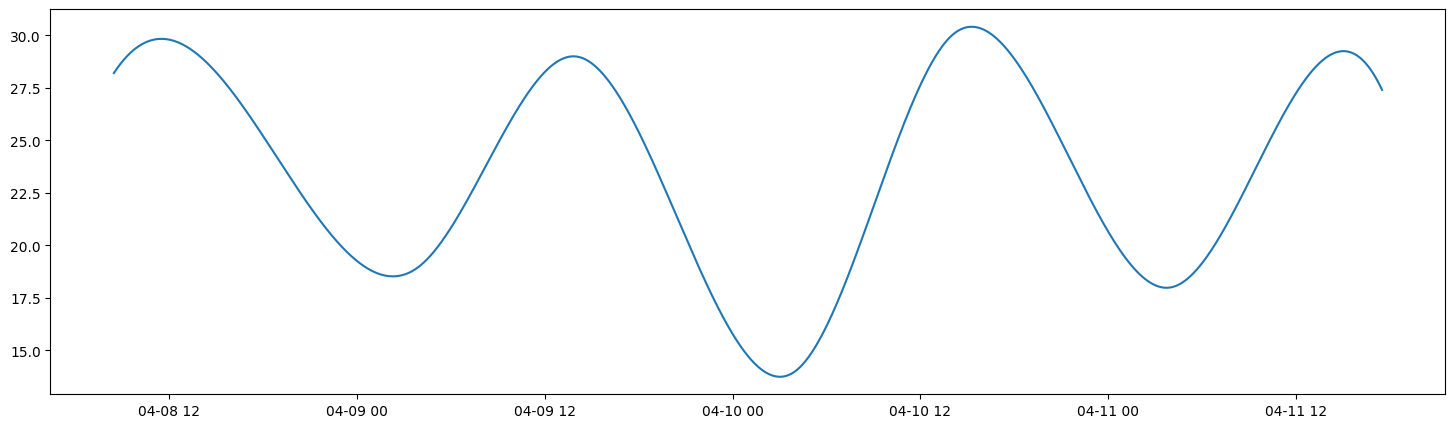

In [7]:
plt.figure(figsize=(18,5))
plt.plot(df_temp_envi[Cols.date_time], df_temp_envi[Cols.temp_environment])

### 保存处理后的数据

In [8]:
df_processed = df_temp_envi
# 输出路径的目录部分
target_folder = r'D:\Devs\Simulation-Platform\data\processed\Test data Hyzenis'

#### 保存为xlsx

In [9]:
df_processed.to_excel(
    os.path.join(
        target_folder,
        '2025.04.08-8.30-2025.04.11-17.30-10s-1#.xlsx'
    )
)

#### 保存为二进制gzip文件

In [10]:
with gzip.open(
    os.path.join(
        target_folder,
        '2025.04.08-8.30-2025.04.11-17.30-10s-1# gzip'
    ),'wb'
) as f:
    pickle.dump(df_processed,f)